# Query-by-Example (QbE) Search Using DTW

## Preliminary

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from __future__ import division
from __future__ import print_function
from os import path
from python_speech_features import delta
from python_speech_features import mfcc
import glob
import matplotlib.pyplot as plt
import numpy as np
import scipy.io.wavfile as wav
import sys
import simpleaudio as sa
from pydub import AudioSegment
from pydub.playback import play
from shennong.audio import Audio
from shennong.features.processor.mfcc import MfccProcessor
from shennong.features.postprocessor.delta import DeltaPostProcessor
from shennong.features.postprocessor.cmvn import CmvnPostProcessor
from progress.bar import Bar
from datetime import datetime
from nltk import word_tokenize
import nltk
nltk.download('punkt')
import Levenshtein as lev
import pickle

sys.path.append("..")
sys.path.append(path.join("..", "utils"))

from speech_dtw import qbe

/home/josh/miniconda3/lib/python3.7/site-packages/pydub/utils.py:165: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)
/home/josh/miniconda3/lib/python3.7/site-packages/pydub/utils.py:179: RuntimeWarning: Couldn't find ffplay or avplay - defaulting to ffplay, but may not work
  warn("Couldn't find ffplay or avplay - defaulting to ffplay, but may not work", RuntimeWarning)
[nltk_data] Downloading package punkt to /home/josh/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Extract features

In [3]:
def get_mfcc_dd(wav_fn):
    """Return the MFCCs with deltas and delta-deltas for a audio file."""
    audio = Audio.load(wav_fn)
    processor = MfccProcessor(sample_rate=audio.sample_rate, window_type="hamming",frame_length=0.025, frame_shift=0.01,
                              cepstral_lifter=26.0,low_freq=0, vtln_low=60, vtln_high=7200, high_freq=audio.sample_rate/2)
    d_processor = DeltaPostProcessor(order=2)
    mfcc_static = processor.process(audio.channel(1), vtln_warp=1.0)
    mfcc_deltas = d_processor.process(mfcc_static)
    #print(mfcc_static.shape, mfcc_deltas.shape)
    features = mfcc_deltas._to_dict()["data"]
    features = (features - np.mean(features, axis=0)) / np.std(features, axis=0)
    #print(features.shape)
    return features

In [5]:
#words_txt = 'english_words/common_words_500.txt'
#words_dir = 'english_words/500_common'
#word_wav = 'common_word_*.wav'
ftitle = '50_extracted_words'
plot_title = ' (50 Extracted words'
#words_txt = 'english_words/redfern_words.txt'
words_dir = 'english_words/redfern_orgnl'
word_wav = '*.wav'
target_speech_dir = 'redfern_original'
#target_speech_dir = 'redfern_rspk'
target_speech_txt = 'redfern_*.txt'
target_speech_wav = 'redfern_*.wav'

## Take Query Words

In [9]:
from nltk.corpus import stopwords 
nltk.download('stopwords')
stopwords = set(stopwords.words('english'))
additional_stopwords = ['i','mr','and', 'says', 'oh', 'never', 'take', 'whatever', 'might', 'say', 'non', 'well', 'get', 'like', 'know', 'think', 'much', 'could', 'said', 'really', 'actually', 'cannot', 'us', 'things']
new_stopwords = stopwords.union(additional_stopwords)
word_list = []
i = 0
for wav_fn in sorted(glob.glob(path.join(words_dir, word_wav))):
    if i < 300:
        query = {} 
        txt_file = open(wav_fn.replace('wav','txt'), "r")
        query["word"] = txt_file.read()
        if query["word"] not in new_stopwords:
            rate, signal = wav.read(wav_fn)
            length = len(signal) / rate * 1000
            query_mfcc = get_mfcc_dd(wav_fn)   
            query["length"] = length
            query["data"] = query_mfcc
            print(query["word"], end=' ')
            query["audio"] = AudioSegment.from_file(wav_fn, format="wav")
            query["thres"] = 1
            #play(query["audio"])
            word_list.append(query)
            i+=1
    else:
        break

[nltk_data] Downloading package stopwords to /home/josh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Aboriginal Australia beginning Commission committed contained contemporary continent contributions Council culture democracy demoralisation dispossessed environment failed failure fundamental generation history identity ignorance imagine Indigenous Islander justice knowledge living opponents opportunity participation partnership people practical prejudice problems reality recognise recognition remarkable settlement social Strait Torres traditional 

In [10]:
print(len(word_list))
print(word_list[3]["word"])
#play(word_list[3]["audio"])
#print(query["data"].shape)

45
Commission


## Take Target Speech Utterances

In [11]:
speech_utt = []
for wav_fn in sorted(glob.glob(path.join(target_speech_dir, target_speech_wav))):
    dic = {}
    dic["audio"] = AudioSegment.from_file(wav_fn, format="wav")
    dic["data"] = get_mfcc_dd(wav_fn)
    txt_file = open(wav_fn.replace('wav','txt'), "r")
    dic["word"] = txt_file.read()
    speech_utt.append(dic)

print(speech_utt[5]['word'])  
#play(speech_utt[5]['audio'])

This is a fundamental test of our social goals and our national will:


culture
It will be a year of great significance for Australia.


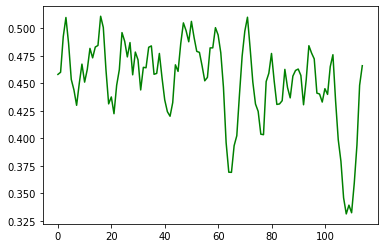

In [12]:
print(word_list[10]["word"])
print(speech_utt[2]["word"])
#print(redfern_word_list[1]["data"], redfern_rspk[2]["data"])
#print(np.float64(redfern_word_list[1]["data"]), np.float64(redfern_rspk[2]["data"]))
sweep_original = qbe.dtw_sweep(np.float64(word_list[10]["data"]), np.float64(speech_utt[2]["data"]))
plt.plot(sweep_original,color='green')
play(word_list[10]['audio'])
play(speech_utt[2]["audio"])

In [13]:
print(len(speech_utt))

111


In [14]:
from tqdm import tqdm
from statistics import mean
result = []
num_uttword = 0
num_match = 0 
num_prediction = 0
num_nomatch = 0
thres_distance = 0
common_words_penalty = 1.2
correct_dtw_score = []
incorrect_dtw_score = []

for uttr in tqdm(range(0,len(speech_utt))):
    dic = {}
    dic['correct_words'] = []
    dic['incorrect_words'] = []
    dic['correct_dtw'] = []
    dic['incorrect_dtw'] = []
    match = set()
    close_words = set()
    for query in word_list:        
        query_word = query["word"].lower()
        query_mfcc = np.float64(query["data"])
        search_mfcc = np.float64(speech_utt[uttr]["data"])
        dtw_costs = qbe.dtw_sweep(query_mfcc, search_mfcc)
        min_dtw = np.min(dtw_costs)
        utt_sent = word_tokenize(speech_utt[uttr]['word'].lower())
        hasMatch = False
        dic['sentence'] = utt_sent                
                
        for utt_word in utt_sent:
            if lev.distance(query_word,utt_word)<=thres_distance:
                dic['correct_words'].append(utt_word)
                dic['correct_dtw'].append(min_dtw)
                correct_dtw_score.append(min_dtw)
                dic['time']=dtw_costs.index(min_dtw)*3/100
                #print('{:<20}'.format(utt_word), end=' ')
                #print('{:<20}'.format(query_word), end=' ')
                #print("%0.3f" % min_dtw, end='\t')
                #print(dic['time'])
                hasMatch = True
                #print('spotted_words:')
                #print(query_word,min_dtw)
                break
                
        if hasMatch == False:
            dic['incorrect_words'].append(query_word)
            dic['incorrect_dtw'].append(min_dtw)
            incorrect_dtw_score.append(min_dtw)
            #print('incorrect_words:')
            #print(query_word,min_dtw)        
        
    num_uttword += len(utt_sent)
    #num_prediction += len(match)
    num_match += len(dic['correct_words'])
    num_nomatch += len(dic['incorrect_words'])

    #word_recognition_rate, precision, recall = get_score(num_uttword, num_spotted, num_prediction, num_unspotted)     
    result.append(dic)
#    if len(correct_dtw_score)>0:
#        print('\nCorrect DTW Average:', end=' ')
#        print(mean(correct_dtw_score))
#    print('Incorrect DTW Average:', end=' ')
#    print(mean(incorrect_dtw_score))
#    print('\n') 
print('\nCorrect DTW Average:', end=' ')
print(mean(correct_dtw_score))
print('Incorrect DTW Average:', end=' ')
print(mean(incorrect_dtw_score))
print('Number of Matching Words:', end=' ')
print(num_match)
print('Done\n') 

100%|██████████| 111/111 [06:04<00:00,  3.28s/it]


Correct DTW Average: 0.21948824847020115
Incorrect DTW Average: 0.35206501619790426
Number of Matching Words: 192
Done



In [15]:
print('\nCorrect DTW Average:', end=' ')
print(mean(correct_dtw_score))
print('Incorrect DTW Average:', end=' ')
print(mean(incorrect_dtw_score))
print('Number of Total Words:', end=' ')
print(num_uttword)
print('Number of Match Words:', end=' ')
print(num_match)


Correct DTW Average: 0.21948824847020115
Incorrect DTW Average: 0.35206501619790426
Number of Total Words: 2173
Number of Match Words: 192


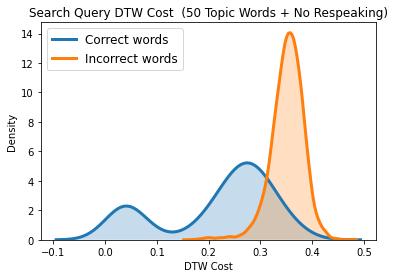

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.kdeplot(correct_dtw_score, shade=True, linewidth = 3, label = 'Correct words')
sns.kdeplot(incorrect_dtw_score, shade=True, linewidth = 3, label = 'Incorrect words')
    
# Plot formatting
plt.legend(prop={'size': 12})
plt.title('Search Query DTW Cost ' + plot_title)
plt.xlabel('DTW Cost')
plt.ylabel('Density')
plt.savefig(ftitle+'_dtw.png', dpi=400)

In [18]:
def get_score(dtw_threshold, match_dtw_score, nomatch_dtw_score, word_count):
    num_spotted = len(list(filter(lambda x: x < dtw_threshold, match_dtw_score)))
    num_uttword = word_count
    num_incorrect = len(list(filter(lambda x: x < dtw_threshold, nomatch_dtw_score)))
    #print(num_spotted, num_incorrect)
    num_match = num_incorrect + num_spotted
    num_unspotted = len(match_dtw_score) - num_spotted
    
   #print(num_spotted, num_uttword, num_incorrect, num_match, num_unspotted)
       
    #word_recognition_rate = num_spotted/num_uttword
    precision = num_spotted/num_match
    recall = num_spotted/(num_spotted+num_unspotted)
   #print(word_recognition_rate, precision, recall)
    return precision, recall

## Get Precisions and Recalls

2173
DTW: 0.27108824847019
Precision: 0.6
Recall: 0.609375
Max F1: 0.6046511627906976


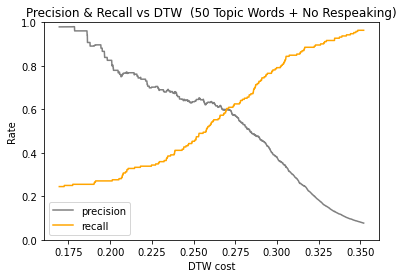

In [19]:
from matplotlib.pyplot import plot, title, xlabel, ylabel, savefig, legend, ylim
from numpy import array, arange

dtw_performance = []
dtw_threshold = []
max_f1 = 0

word_count = 0
for uttr in result:
    word_count += len(uttr['sentence'])
print(word_count)   

hasFoundRecall = False
for i in arange(mean(correct_dtw_score)-0.05,mean(incorrect_dtw_score),0.0001):
    p, r = get_score(i, correct_dtw_score, incorrect_dtw_score, word_count)
    f1 = 2*((p*r)/(p+r))
    if f1>max_f1:
        max_f1=f1
        default_dtw = i
        best_p = p
        best_r = r
    dtw_performance.append((p,r))
    dtw_threshold.append(i)
    
print('DTW: '+str(default_dtw)+'\nPrecision: '+str(best_p)+'\nRecall: '+str(best_r))
print('Max F1: '+str(max_f1))
dtw_threshold = array(dtw_threshold) 
#print(dtw_performance)
#print(dtw_threshold)

#recognised, 
precision, recall = zip(*dtw_performance)
colors_and_labels = (
   # (recognised, 'green', 'rate'),
    (precision, 'grey', 'precision'),
    (recall, 'orange', 'recall')
)

for performance, color, label in colors_and_labels:
    plot(dtw_threshold, array(performance), color=color, label=label)
title('Precision & Recall vs DTW '+plot_title)
xlabel('DTW cost')
ylabel('Rate')
ylim(0,1)
legend()

savefig(ftitle+'_accuracy.png', dpi=400)

In [20]:
#uttrances = [4,43,71,55,32]
uttrances = [4,44,70,54,31]
for uttr_id in uttrances:
    spotted_words = []
    false_words = []
    fail_to_spot = []
    match = set()
    close_words = set()
    for query in word_list:        
        query_word = query["word"].lower()
        query_mfcc = np.float64(query["data"])
        search_mfcc = np.float64(speech_utt[uttr_id]["data"])
        dtw_costs = qbe.dtw_sweep(query_mfcc, search_mfcc)
        min_dtw = np.min(dtw_costs)
        utt_sent = word_tokenize(speech_utt[uttr_id]['word'].lower().replace('-',' '))
        hasMatch = False               

        for utt_word in utt_sent:
            if min_dtw < default_dtw:
                if lev.distance(query_word,utt_word)<=thres_distance:
                    spotted_words.append(utt_word)
                    hasMatch = True
                    #print('Correct:')
                    #print(query_word)
                    break
            else:
                if lev.distance(query_word,utt_word)<=thres_distance:
                    #print(query_word,utt_word)
                    fail_to_spot.append(utt_word)
                
        if hasMatch == False and min_dtw < default_dtw:
            false_words.append(query_word) 
                #print('Incorrect:')
                #print(query_word)
        
                #print('Fail to Spot:')
                #print(query_word)

    print('Utterance: \t'+speech_utt[uttr_id]['word'])
    print('Spotted Words:', end='\t')
    for word in spotted_words:
        print(word, end=' ') 
    print('\nFalse Positive:', end='\t')
    for word in false_words:
        print(word, end=' ')
    print('\nFailed to Spot:', end='\t')
    for word in fail_to_spot:
        print(word, end=' ')
    print('\n') 


Utterance: 	Because, in truth, we cannot confidently say that we succeeded if we have not managed to extend opportunity and care, dignity and hope to the indigenous people of Australia - the Aboriginal and Torres Strait Island people.
Spotted Words:	opportunity strait 
False Positive:	
Failed to Spot:	aboriginal australia indigenous people people torres 

Utterance: 	It begins, I think, with that act of recognition recognition that it was we who did the dispossessing.
Spotted Words:	recognition 
False Positive:	
Failed to Spot:	

Utterance: 	By doing away with the bizarre concept that this continent had no owners prior to the settlement of Europeans, Mabo establishes a fundamental truth and lays the basis for justice.
Spotted Words:	continent justice settlement 
False Positive:	strait 
Failed to Spot:	fundamental 

Utterance: 	If we need a reminder of this we received it in this year with the report of the Royal Commission into the Aboriginal Deaths in Custody which showed with devasta

## Save Data

In [21]:
data = {}
data['result'] = result
data['match_dtw'] = correct_dtw_score
data['nomatch_dtw'] = incorrect_dtw_score

In [22]:
with open(ftitle+'.data', 'wb') as filehandle:
    pickle.dump(data, filehandle)